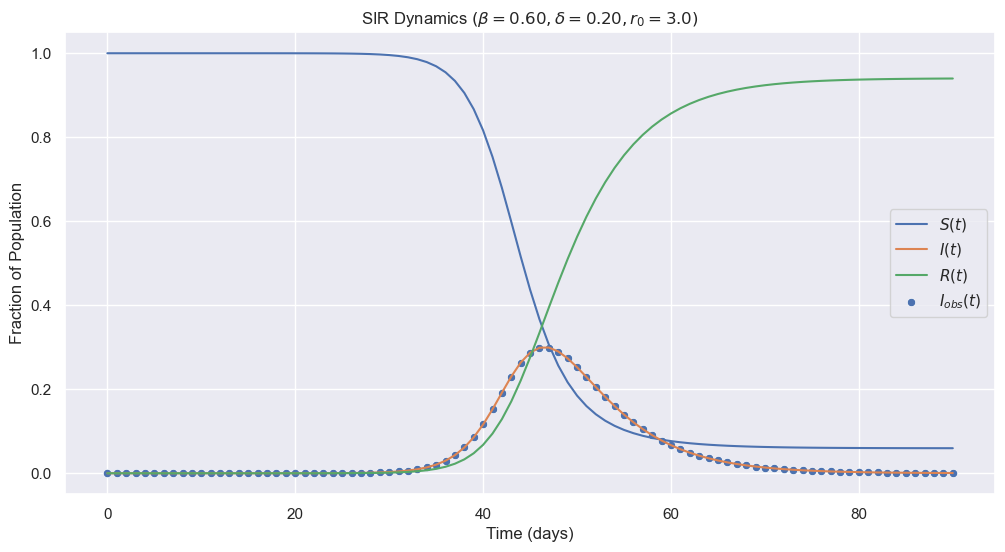

In [175]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import display, HTML
from scipy.integrate import odeint
from sklearn.metrics import mean_absolute_percentage_error

# if torch.backends.mps.is_available():
#   torch.set_default_device("mps")

figures_dir = "figures"
data_dir = "data"
sns.set_theme(style="darkgrid")

# True SIR parameters for data generation
N = 56e6  # Total population (for scaling)
delta = 1 / 5  # Recovery rate (per day)
r0 = 3.0  # Basic reproduction number
beta_true = delta * r0  # Infection rate (per day)


def sir(x, _, d, b):
  s, i, r = x
  l = b * i / N
  ds_dt = -l * s
  di_dt = l * s - d * i
  dr_dt = d * i
  return np.array([ds_dt, di_dt, dr_dt])


# Initial conditions (actual population counts)
S0 = N - 1
I0 = 1
R0 = 0

# Time domain for simulation
t_start, t_end = 0, 90  # days
t = np.linspace(t_start, t_end, t_end - t_start + 1)

solution = odeint(sir, [S0, I0, R0], t, args=(delta, beta_true))
s_true = solution[:, 0]
i_true = solution[:, 1]
r_true = solution[:, 2]

i_obs = np.random.poisson(i_true)

# Scale initial conditions to fractions of the population
S0_sc = S0 / N
I0_sc = I0 / N
R0_sc = R0 / N

s_true = s_true / N
i_true = i_true / N
r_true = r_true / N
i_obs = i_obs / N

plt.subplots(figsize=(12, 6))

sns.lineplot(x=t, y=s_true, label=r"$S(t)$")
sns.lineplot(x=t, y=i_true, label=r"$I(t)$")
sns.lineplot(x=t, y=r_true, label=r"$R(t)$")
sns.scatterplot(x=t, y=i_obs, label=r"$I_{obs}(t)$")

plt.title(
  f"SIR Dynamics $\\left(\\beta={beta_true:.2f}, \\delta={delta:.2f}, r_0={r0}\\right)$"
)
plt.xlabel("Time (days)")
plt.ylabel("Fraction of Population")

plt.savefig(f"{figures_dir}/synthetic_data.png")

In [176]:
# Convert observation data to torch tensors for training
t_tensor = torch.tensor(t, dtype=torch.float32).reshape(-1, 1)
I_obs_tensor = torch.tensor(i_obs, dtype=torch.float32).reshape(-1, 1)

# Hyperparameters
n_collocation = 100  # number of collocation points sampled per iteration
n_iterations = 60000  # training iterations for Adam optimizer
log_interval = 1000  #
learning_rate = 1e-3  # learning rate for Adam

# Loss weights for PDE, initial condition, and data components
w_pde = 1.0
w_ic = 10.0
w_data = 1.0

# Initial guess for unknown parameter β
beta_initial_guess = 0.3


In [177]:
import torch.nn as nn


# Define a fully-connected neural network (FNN) for one compartment (S, I, or R)
class FNN(nn.Module):
  def __init__(
      self,
      input_dim=1,
      output_dim=1,
      hidden_layers=[64, 64, 64, 64],
      activation=nn.Tanh()
  ):
    super(FNN, self).__init__()
    layers = []
    prev_dim = input_dim
    # Hidden layers
    for h in hidden_layers:
      layers.append(nn.Linear(prev_dim, h))
      layers.append(activation)
      prev_dim = h
    # Output layer
    layers.append(nn.Linear(prev_dim, output_dim))
    self.model = nn.Sequential(*layers)
    # Initialize weights and biases (Xavier initialization for weights, zeros for biases)
    for m in self.model:
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

  def forward(self, x):
    return self.model(x)


# Instantiate separate networks for S(t), I(t), and R(t)
S_net = FNN()
I_net = FNN()
R_net = FNN()

# Define β as a trainable parameter
beta_param = torch.nn.Parameter(
  torch.tensor(beta_initial_guess, dtype=torch.float32)
)

# Collect all parameters for the optimizer
params = (
    list(S_net.parameters()) +
    list(I_net.parameters()) +
    list(R_net.parameters()) +
    [beta_param]
)

# Set up the Adam optimizer
optimizer = torch.optim.Adam(params, lr=learning_rate)


In [178]:
# Define mean squared error loss function
mse_loss = nn.MSELoss()


# Helper: compute SIR ODE residuals at given time points t
def compute_pde_residuals(t):
  """Compute residuals of SIR ODE at times t.
  Returns res_S, res_I, res_R as tensors of the same shape as t."""
  # Ensure t is set for autograd
  t = t.detach().clone().requires_grad_(True)
  # Network predictions
  S_pred = S_net(t)
  I_pred = I_net(t)
  R_pred = R_net(t)
  # Time derivatives via autograd
  dS_dt = torch.autograd.grad(
    S_pred,
    t,
    grad_outputs=torch.ones_like(S_pred),
    create_graph=True
  )[0]
  dI_dt = torch.autograd.grad(
    I_pred,
    t,
    grad_outputs=torch.ones_like(I_pred),
    create_graph=True
  )[0]
  dR_dt = torch.autograd.grad(
    R_pred,
    t,
    grad_outputs=torch.ones_like(R_pred),
    create_graph=True
  )[0]
  # ODE residuals (using scaled variables so N=1 in equations)
  res_S = dS_dt + beta_param * S_pred * I_pred  # = 0 for true solution
  res_I = dI_dt - beta_param * S_pred * I_pred + delta * I_pred  # = 0 for true solution
  res_R = dR_dt - delta * I_pred  # = 0 for true solution
  return res_S, res_I, res_R


# Loss component: ODE/PDE (physics) loss
def loss_pde(t_coll):
  res_S, res_I, res_R = compute_pde_residuals(t_coll)
  # Compute MSE for each residual against 0
  loss_res_S = mse_loss(res_S, torch.zeros_like(res_S))
  loss_res_I = mse_loss(res_I, torch.zeros_like(res_I))
  loss_res_R = mse_loss(res_R, torch.zeros_like(res_R))
  return loss_res_S + loss_res_I + loss_res_R


# Loss component: initial condition loss at t=0
def loss_ic():
  t0_tensor = torch.tensor([[0.0]], dtype=torch.float32)
  S0_pred = S_net(t0_tensor)
  I0_pred = I_net(t0_tensor)
  R0_pred = R_net(t0_tensor)
  # MSE for each initial condition
  loss_S0 = (S0_pred - S0_sc) ** 2
  loss_I0 = (I0_pred - I0_sc) ** 2
  loss_R0 = (R0_pred - R0_sc) ** 2
  # sum (or equivalently average, up to weight scaling) the three
  return loss_S0 + loss_I0 + loss_R0


# Loss component: observation data loss at known data points
def loss_data():
  I_pred = I_net(t_tensor)
  # MSE on each compartment's observed values
  loss_I = mse_loss(I_pred, I_obs_tensor)
  return loss_I


In [179]:
# Training loop
pde_losses = []
ic_losses = []
data_losses = []
total_losses = []
beta_history = []

for it in range(1, n_iterations + 1):
  optimizer.zero_grad()
  # Sample random collocation points in the time domain
  t_coll = torch.rand(n_collocation, 1) * t_end  # uniform random in [0, 90]
  # Compute individual loss components
  L_pde = loss_pde(t_coll)
  L_ic = loss_ic()
  L_data = loss_data()
  # Combine losses with weights
  loss = w_pde * L_pde + w_ic * L_ic + w_data * L_data
  # Backpropagation and optimizer step
  loss.backward()
  optimizer.step()
  # Log losses and beta
  pde_losses.append(L_pde.item())
  ic_losses.append(L_ic.item())
  data_losses.append(L_data.item())
  total_losses.append(loss.item())
  beta_history.append(beta_param.item())
  # Print progress occasionally
  if it % 1000 == 0:
    print(
      f"Iteration {it}: Total Loss = {loss.item():.3e}, β = {beta_param.item():.4f}"
    )


Iteration 1000: Total Loss = 2.790e-03, β = 0.2724
Iteration 2000: Total Loss = 2.332e-04, β = 0.2611
Iteration 3000: Total Loss = 2.087e-04, β = 0.2641
Iteration 4000: Total Loss = 1.730e-04, β = 0.2715
Iteration 5000: Total Loss = 3.066e-04, β = 0.2896
Iteration 6000: Total Loss = 3.712e-04, β = 0.2944
Iteration 7000: Total Loss = 2.204e-04, β = 0.3089
Iteration 8000: Total Loss = 2.495e-04, β = 0.2980
Iteration 9000: Total Loss = 2.622e-04, β = 0.3175
Iteration 10000: Total Loss = 5.360e-05, β = 0.4730
Iteration 11000: Total Loss = 1.433e-05, β = 0.5514
Iteration 12000: Total Loss = 4.049e-05, β = 0.5573
Iteration 13000: Total Loss = 4.944e-05, β = 0.5744
Iteration 14000: Total Loss = 3.376e-05, β = 0.5782
Iteration 15000: Total Loss = 5.975e-06, β = 0.5817
Iteration 16000: Total Loss = 1.653e-04, β = 0.5756
Iteration 17000: Total Loss = 2.440e-06, β = 0.5858
Iteration 18000: Total Loss = 5.120e-06, β = 0.5173
Iteration 19000: Total Loss = 1.141e-04, β = 0.5681
Iteration 20000: Tota

In [180]:
loss_df = pd.DataFrame(
  {
    'pde_loss':   pde_losses,
    'ic_loss':    ic_losses,
    'data_loss':  data_losses,
    'total_loss': total_losses
  }
)

beta_df = pd.DataFrame(
  {
    'beta': beta_history
  }
)

loss_df.to_csv(f"{data_dir}/loss_history.csv", float_format='%.6e')
beta_df.to_csv(f"{data_dir}/beta_history.csv", float_format='%.6e')

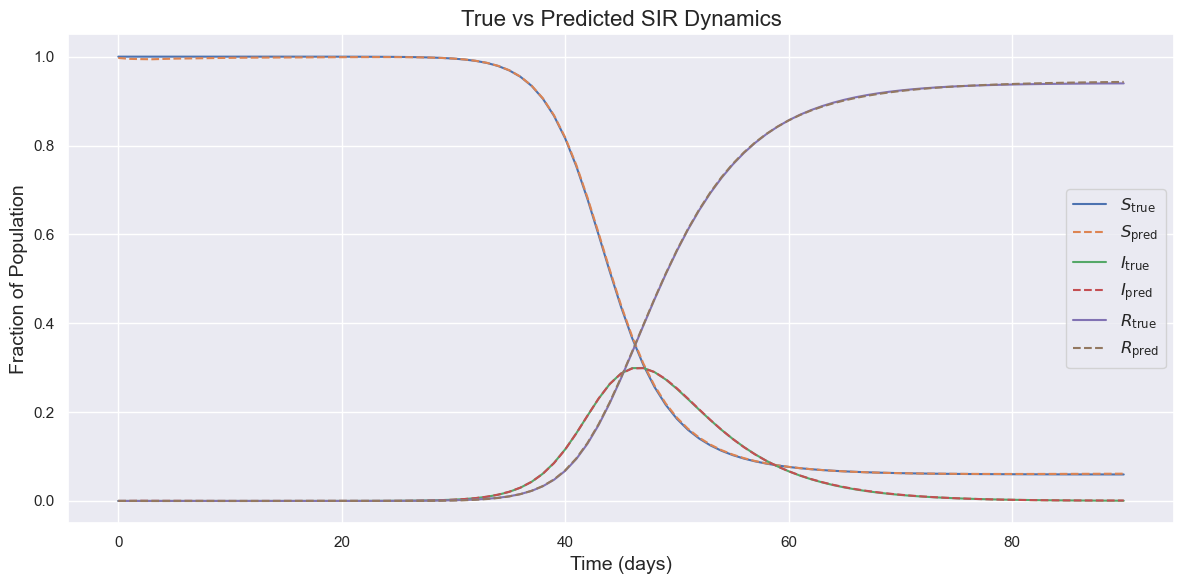

In [181]:
s_pred = S_net(t_tensor).cpu().detach().numpy().flatten()
i_pred = I_net(t_tensor).cpu().detach().numpy().flatten()
r_pred = R_net(t_tensor).cpu().detach().numpy().flatten()
t_pred = t_tensor.cpu().detach().numpy().flatten()

plt.figure(figsize=(12, 6))

sns.lineplot(x=t_pred, y=s_true, label="$S_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=s_pred, label="$S_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_pred, y=i_true, label="$I_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=i_pred, label="$I_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_pred, y=r_true, label="$R_{\mathrm{true}}$")
sns.lineplot(x=t_pred, y=r_pred, label="$R_{\mathrm{pred}}$", linestyle="--")

plt.title('True vs Predicted SIR Dynamics', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Fraction of Population', fontsize=14)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig(f"{figures_dir}/sir_preditions.png")

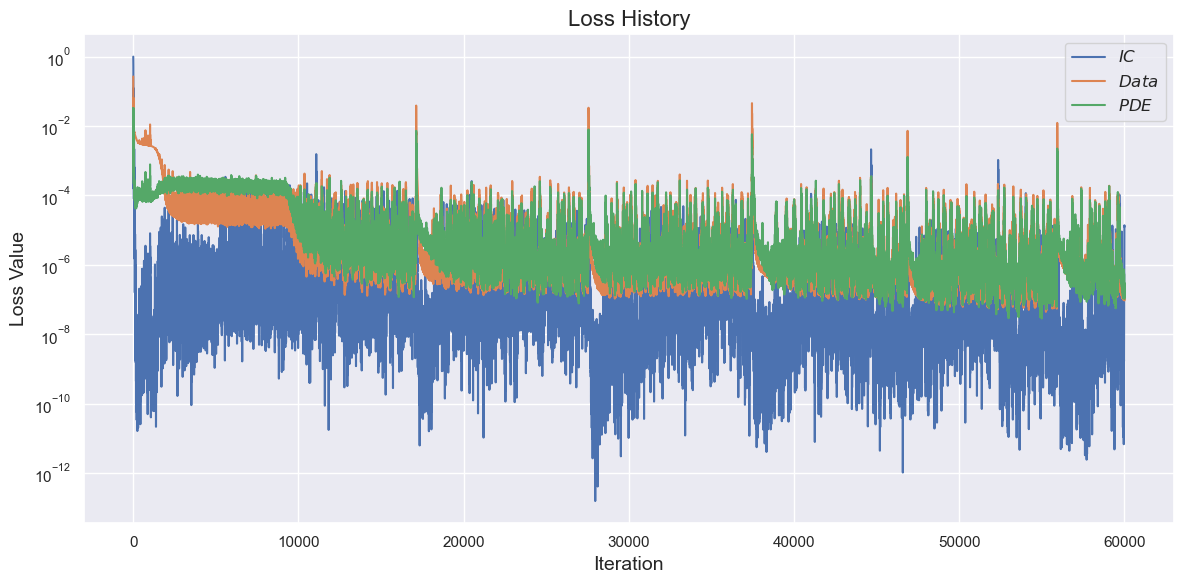

In [182]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=loss_df['ic_loss'], label='$IC$')
sns.lineplot(data=loss_df['data_loss'], label='$Data$')
sns.lineplot(data=loss_df['pde_loss'], label='$PDE$')

plt.title('Loss History', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Loss Value', fontsize=14)
plt.yscale('log')

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig(f'{figures_dir}/loss_history.png', dpi=300)

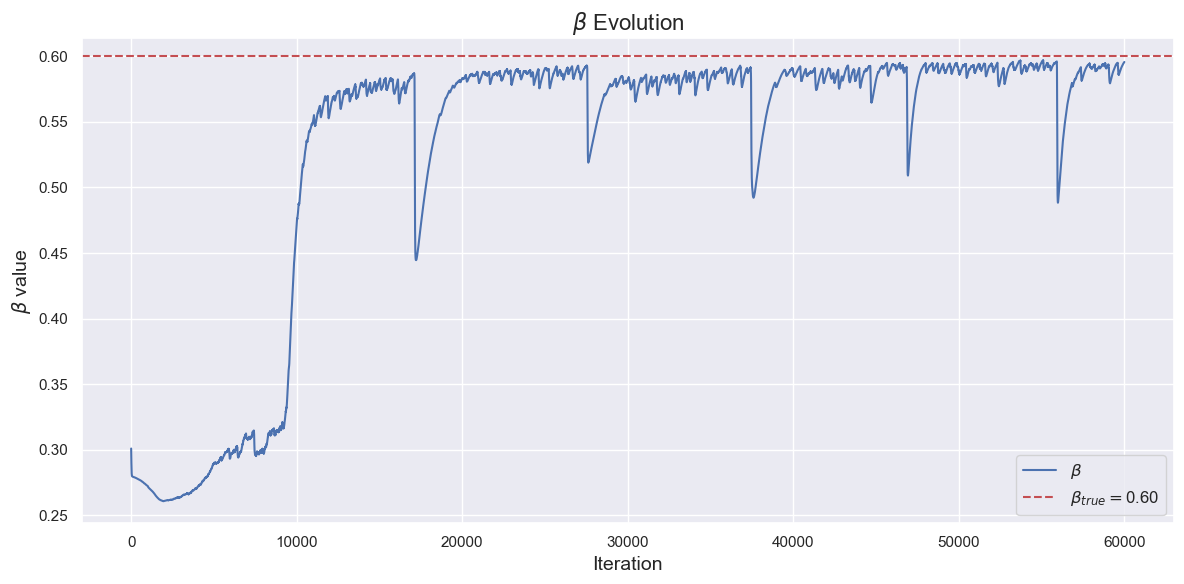

In [183]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=beta_df['beta'], label='$\\beta$')
plt.axhline(
  y=beta_true,
  color='r',
  linestyle='--',
  label='$\\beta_{true} = $' + f'{beta_true:.2f}'
)

plt.title(f'$\\beta$ Evolution', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$\\beta$ value', fontsize=14)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig(f'{figures_dir}/beta_evolution.png', dpi=300)

In [184]:
def mse(pred, true):
  """Calculate Mean Squared Error between predicted and true values."""
  return np.mean((pred - true) ** 2)


def re(pred, true):
  """Calculate Relative Error between predicted and true values."""
  return np.linalg.norm(true - pred, 2) / np.linalg.norm(true, 2)


def mape(pred, true):
  """Calculate Mean Absolute Percentage Error between predicted and true values."""
  return mean_absolute_percentage_error(true, pred)


compartments = ["S", "I", "R"]
pred_arrays = [s_pred, i_pred, r_pred]
true_arrays = [s_true, i_true, r_true]

mse_values = [
  f"{mse(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]
re_values = [
  f"{re(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]
mape_values = [
  f"{mape(pred, true):.2e}" for pred, true in zip(pred_arrays, true_arrays)
]

errors = pd.DataFrame(
  {
    "Compartment": compartments,
    "MSE":         mse_values,
    "MAPE (%)":    mape_values,
    "RE":          re_values,
  }
)

display(HTML(errors.to_html(index=False)))

Compartment,MSE,MAPE (%),RE
S,4.39e-06,5.82e-03,3.07e-03
I,1.22e-07,3.37e+02,3.47e-03
R,1.48e-06,1.62e+07,2.03e-03


In [185]:
beta_error = abs(beta_param.item() - beta_true)
beta_error_percent = beta_error / beta_true * 100

beta_errors = pd.DataFrame(
  {
    "Parameter":          ["β"],
    "Learned Value":      [f"{beta_param.item():.4f}"],
    "True Value":         [f"{beta_true:.4f}"],
    "Absolute Error":     [f"{beta_error:.2e}"],
    "Relative Error (%)": [f"{beta_error_percent:.2f}%"],
  }
)

display(HTML(beta_errors.to_html(index=False)))

Parameter,Learned Value,True Value,Absolute Error,Relative Error (%)
β,0.5956,0.6000,4.35e-03,0.73%
